# Quantitative Market Analysis: Bonds, Stocks, and Yield Curve Dynamics

## Project Overview

This project investigates the interaction between long-term U.S. Treasuries (TLT), short-term Treasuries (SHY), and equities (SPY) to understand yield curve dynamics and their impact on relative asset performance.

The core hypothesis is that the slope of the yield curve (difference between long- and short-term rates) can be used as a signal for bond market relative value trades, and potentially as a macroeconomic indicator for equities.

**Key Concepts:**

- **TLT** (iShares 20+ Year Treasury Bond ETF) → proxy for long-duration Treasuries.

- **SHY** (iShares 1-3 Year Treasury Bond ETF) → proxy for short-duration Treasuries.

- **SPY** (S&P 500 ETF) → benchmark for equity performance.

- **Yield Curve Steepening**: Long-term yields rise relative to short-term yields → long bonds underperform.

- **Yield Curve Flattening**: Long-term yields fall relative to short-term yields → long bonds outperform.


**Research Goals**

- Quantify the relationship between yield curve changes and TLT vs. SHY relative performance.

- Compare volatility and correlations across bonds and equities.

- Evaluate historical performance metrics (Sharpe, drawdowns, Calmar ratio).

- Conduct regime-based analysis (inversions, steep/flat regimes) to explore predictive relationships.

# 1. Import Libraries and Setup

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import pandas_datareader.data as web
import warnings
warnings.filterwarnings('ignore')

## Download ETF price data

In [2]:
start_date = "2010-01-01"
end_date = "2024-12-31"
etf_symbols = ['TLT', 'SHY', 'SPY']
etf_prices = yf.download(etf_symbols, start=start_date, end=end_date)['Close']
etf_prices

[*********************100%***********************]  3 of 3 completed


Ticker,SHY,SPY,TLT
Date,,,
2010-01-04,67.625786,85.515610,57.812893
2010-01-05,67.707176,85.741997,58.186256
2010-01-06,67.715340,85.802422,57.407394
2010-01-07,67.699074,86.164566,57.503899
2010-01-08,67.764229,86.451294,57.478180
...,...,...,...
2024-12-23,79.898354,591.158813,85.320915
2024-12-24,79.937447,597.729492,85.681709
2024-12-26,79.957008,597.769348,85.632957


### Plot raw closing prices

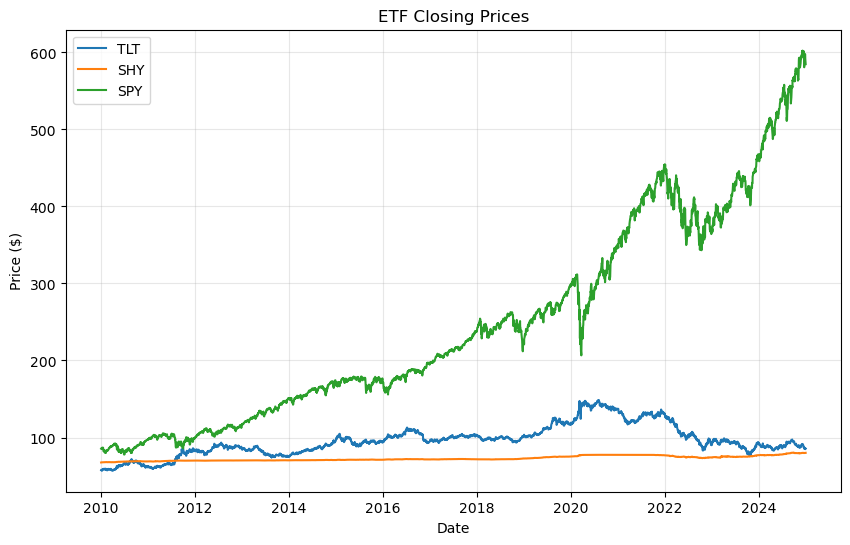

In [3]:
plt.figure(figsize=(10, 6))
for symbol in etf_symbols:
    plt.plot(etf_prices.index, etf_prices[symbol], label=symbol)
plt.title("ETF Closing Prices")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## Download actual Treasury yields from FRED

In [4]:
start_dt = datetime.strptime(start_date, "%Y-%m-%d")
end_dt = datetime.strptime(end_date, "%Y-%m-%d")    

In [5]:
yield_series = {
    '3M': 'DGS3MO',    # 3-month Treasury
    '2Y': 'DGS2',      # 2-year Treasury  
    '10Y': 'DGS10',    # 10-year Treasury
    '30Y': 'DGS30'     # 30-year Treasury
}
yields = {}

for name, series in yield_series.items():
    data = web.DataReader(series, 'fred', start_dt, end_dt)
    yields[name] = data.iloc[:, 0]
    print(f"  ✅ {name} yield: {len(data)} data points")

  ✅ 3M yield: 3913 data points
  ✅ 2Y yield: 3913 data points
  ✅ 10Y yield: 3913 data points
  ✅ 30Y yield: 3913 data points


In [6]:
treasury_yields = pd.DataFrame(yields)
treasury_yields

,3M,2Y,10Y,30Y
DATE,,,,
2010-01-01,NaN,NaN,NaN,NaN
2010-01-04,0.08,1.09,3.85,4.65
2010-01-05,0.07,1.01,3.77,4.59
2010-01-06,0.06,1.01,3.85,4.70
2010-01-07,0.05,1.03,3.85,4.69
...,...,...,...,...
2024-12-25,NaN,NaN,NaN,NaN
2024-12-26,4.35,4.30,4.58,4.76
2024-12-27,4.31,4.31,4.62,4.82


## Combine datasets

In [7]:
data = pd.concat([etf_prices, treasury_yields], axis=1).dropna()
data

,SHY,SPY,TLT,3M,2Y,10Y,30Y
2010-01-04,67.625786,85.515610,57.812893,0.08,1.09,3.85,4.65
2010-01-05,67.707176,85.741997,58.186256,0.07,1.01,3.77,4.59
2010-01-06,67.715340,85.802422,57.407394,0.06,1.01,3.85,4.70
2010-01-07,67.699074,86.164566,57.503899,0.05,1.03,3.85,4.69
2010-01-08,67.764229,86.451294,57.478180,0.05,0.96,3.83,4.70
...,...,...,...,...,...,...,...
2024-12-23,79.898354,591.158813,85.320915,4.36,4.30,4.59,4.78
2024-12-24,79.937447,597.729492,85.681709,4.40,4.29,4.59,4.76
2024-12-26,79.957008,597.769348,85.632957,4.35,4.30,4.58,4.76
2024-12-27,79.976547,591.476868,84.930885,4.31,4.31,4.62,4.82


## Calculate ETF returns

In [8]:
data['TLT_Return'] = data['TLT'].pct_change()
data['SHY_Return'] = data['SHY'].pct_change()
data['SPY_Return'] = data['SPY'].pct_change()

## Yield curve calculations

In [9]:
data['Yield_Spread_10Y2Y'] = data['10Y'] - data['2Y']
data['Yield_Spread_30Y2Y'] = data['30Y'] - data['2Y']
data['Yield_Spread_10Y3M'] = data['10Y'] - data['3M']
data

,SHY,SPY,TLT,3M,2Y,10Y,30Y,TLT_Return,SHY_Return,SPY_Return,Yield_Spread_10Y2Y,Yield_Spread_30Y2Y,Yield_Spread_10Y3M
2010-01-04,67.625786,85.515610,57.812893,0.08,1.09,3.85,4.65,NaN,NaN,NaN,2.76,3.56,3.77
2010-01-05,67.707176,85.741997,58.186256,0.07,1.01,3.77,4.59,0.006458,0.001204,0.002647,2.76,3.58,3.70
2010-01-06,67.715340,85.802422,57.407394,0.06,1.01,3.85,4.70,-0.013386,0.000121,0.000705,2.84,3.69,3.79
2010-01-07,67.699074,86.164566,57.503899,0.05,1.03,3.85,4.69,0.001681,-0.000240,0.004221,2.82,3.66,3.80
2010-01-08,67.764229,86.451294,57.478180,0.05,0.96,3.83,4.70,-0.000447,0.000962,0.003328,2.87,3.74,3.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-23,79.898354,591.158813,85.320915,4.36,4.30,4.59,4.78,-0.009172,-0.000611,0.005988,0.29,0.48,0.23
2024-12-24,79.937447,597.729492,85.681709,4.40,4.29,4.59,4.76,0.004229,0.000489,0.011115,0.30,0.47,0.19
2024-12-26,79.957008,597.769348,85.632957,4.35,4.30,4.58,4.76,-0.000569,0.000245,0.000067,0.28,0.46,0.23
2024-12-27,79.976547,591.476868,84.930885,4.31,4.31,4.62,4.82,-0.008199,0.000244,-0.010527,0.31,0.51,0.31


## TLT vs SHY relative performance

In [10]:
data['TLT_SHY_Ratio'] = data['TLT'] / data['SHY']
data['TLT_SHY_LogRatio'] = np.log(data['TLT_SHY_Ratio'])
data['Relative_Performance'] = data['TLT_Return'] - data['SHY_Return']

## Duration approximation (price sensitivity to yield changes)

In [11]:
data['TLT_Duration_Approx'] = -data['TLT_Return'] / data['10Y'].pct_change()
data

,SHY,SPY,TLT,3M,2Y,10Y,30Y,TLT_Return,SHY_Return,SPY_Return,Yield_Spread_10Y2Y,Yield_Spread_30Y2Y,Yield_Spread_10Y3M,TLT_SHY_Ratio,TLT_SHY_LogRatio,Relative_Performance,TLT_Duration_Approx
2010-01-04,67.625786,85.515610,57.812893,0.08,1.09,3.85,4.65,NaN,NaN,NaN,2.76,3.56,3.77,0.854894,-0.156778,NaN,NaN
2010-01-05,67.707176,85.741997,58.186256,0.07,1.01,3.77,4.59,0.006458,0.001204,0.002647,2.76,3.58,3.70,0.859381,-0.151543,0.005255,0.310798
2010-01-06,67.715340,85.802422,57.407394,0.06,1.01,3.85,4.70,-0.013386,0.000121,0.000705,2.84,3.69,3.79,0.847775,-0.165140,-0.013506,0.630800
2010-01-07,67.699074,86.164566,57.503899,0.05,1.03,3.85,4.69,0.001681,-0.000240,0.004221,2.82,3.66,3.80,0.849405,-0.163220,0.001921,-inf
2010-01-08,67.764229,86.451294,57.478180,0.05,0.96,3.83,4.70,-0.000447,0.000962,0.003328,2.87,3.74,3.78,0.848208,-0.164629,-0.001410,-0.086096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-23,79.898354,591.158813,85.320915,4.36,4.30,4.59,4.78,-0.009172,-0.000611,0.005988,0.29,0.48,0.23,1.067868,0.065664,-0.008561,0.592257
2024-12-24,79.937447,597.729492,85.681709,4.40,4.29,4.59,4.76,0.004229,0.000489,0.011115,0.30,0.47,0.19,1.071859,0.069395,0.003739,-inf
2024-12-26,79.957008,597.769348,85.632957,4.35,4.30,4.58,4.76,-0.000569,0.000245,0.000067,0.28,0.46,0.23,1.070988,0.068581,-0.000814,-0.261165
2024-12-27,79.976547,591.476868,84.930885,4.31,4.31,4.62,4.82,-0.008199,0.000244,-0.010527,0.31,0.51,0.31,1.061947,0.060104,-0.008443,0.938742


### Plot 1: TLT vs SHY Price Performance

This chart compares the **normalized price performance** of long-term Treasuries (TLT), short-term Treasuries (SHY), and equities (SPY), with all series rebased to 100 at the start of the sample. By normalizing prices, the plot highlights relative growth trajectories rather than absolute levels, making it easier to compare long-term trends across asset classes. It shows how bonds and stocks performed relative to each other over time, capturing periods of equity bull markets, bond rallies, and shifts in relative attractiveness between long- and short-duration Treasuries.


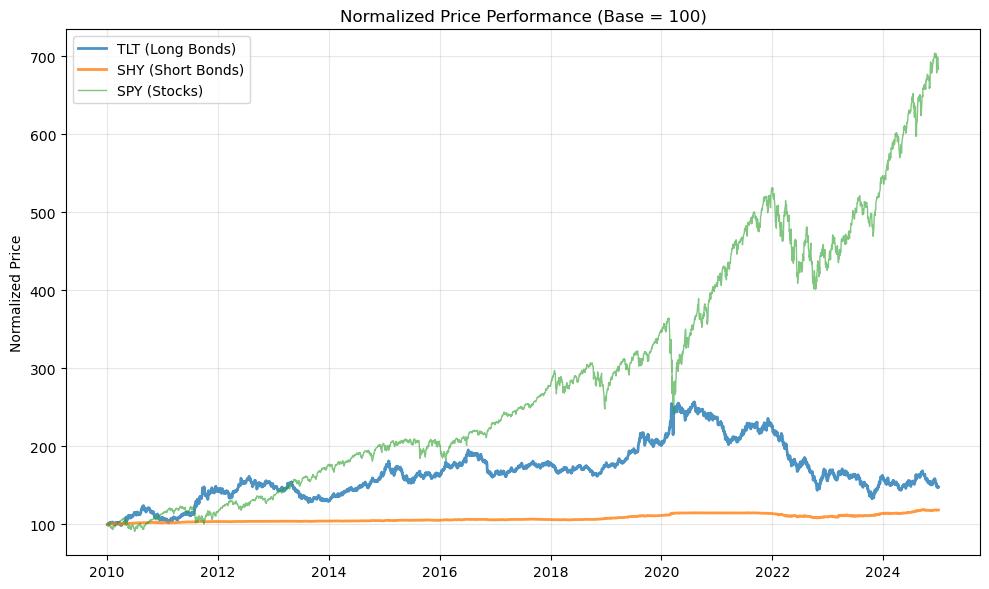

In [12]:
plt.figure(figsize=(10, 6))
norm_tlt = data['TLT'] / data['TLT'].iloc[0] * 100
norm_shy = data['SHY'] / data['SHY'].iloc[0] * 100
norm_spy = data['SPY'] / data['SPY'].iloc[0] * 100

plt.plot(data.index, norm_tlt, label='TLT (Long Bonds)', linewidth=2, alpha=0.8)
plt.plot(data.index, norm_shy, label='SHY (Short Bonds)', linewidth=2, alpha=0.8)
plt.plot(data.index, norm_spy, label='SPY (Stocks)', linewidth=1, alpha=0.6)
plt.title('Normalized Price Performance (Base = 100)')
plt.ylabel('Normalized Price')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Plot 2: Yield Curve Shape (10Y-2Y Spread)

This plot shows the **10Y–2Y Treasury yield spread**, a widely used measure of the yield curve’s shape. Positive values indicate a “normal” yield curve where long-term yields exceed short-term yields, while **negative values (below the red dashed inversion line) represent an inverted curve, often seen as a recession signal**. Periods of inversion are shaded in red, making it clear when the curve has flipped. This visualization helps track the yield curve’s dynamics over time and highlights macroeconomic stress points where inversions have historically occurred.

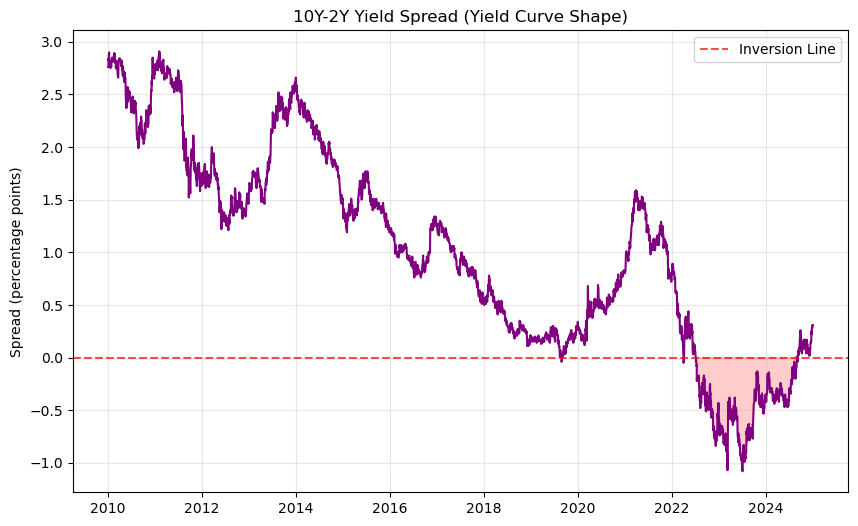

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['Yield_Spread_10Y2Y'], color='purple', linewidth=1.5)
plt.axhline(y=0, color='red', linestyle='--', alpha=0.7, label='Inversion Line')
plt.title('10Y-2Y Yield Spread (Yield Curve Shape)')
plt.ylabel('Spread (percentage points)')
plt.legend()
plt.grid(True, alpha=0.3)
    
# Highlight inversions
inversions = data['Yield_Spread_10Y2Y'] < 0
if inversions.any():
    plt.fill_between(data.index, data['Yield_Spread_10Y2Y'], 0, 
                   where=inversions, color='red', alpha=0.2, label='Inversions')
plt.show()

### Plot 3: TLT/SHY Ratio

This chart plots the **price ratio of TLT to SHY**, which measures the relative performance of long-term versus short-term Treasuries. A rising ratio indicates that long-duration bonds are outperforming short-duration bonds, while a falling ratio signals the opposite. To assess valuation extremes, mean reversion bands are added: the historical average (black line) and ±2 standard deviations (red dashed lines). This helps identify when the ratio deviates significantly from its long-term mean, potentially signaling overextended moves or mean-reversion trading opportunities.


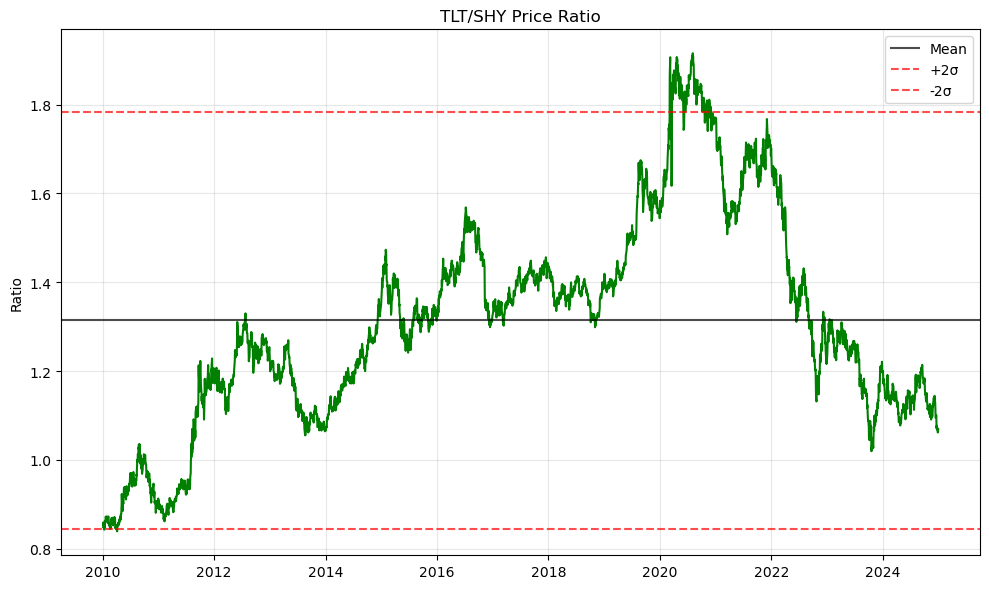

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['TLT_SHY_Ratio'], color='green', linewidth=1.5)
plt.title('TLT/SHY Price Ratio')
plt.ylabel('Ratio')
plt.grid(True, alpha=0.3)

# Add mean reversion lines
ratio_mean = data['TLT_SHY_Ratio'].mean()
ratio_std = data['TLT_SHY_Ratio'].std()
plt.axhline(y=ratio_mean, color='black', linestyle='-', alpha=0.7, label='Mean')
plt.axhline(y=ratio_mean + 2*ratio_std, color='red', linestyle='--', alpha=0.7, label='+2σ')
plt.axhline(y=ratio_mean - 2*ratio_std, color='red', linestyle='--', alpha=0.7, label='-2σ')
plt.legend()
plt.tight_layout()
plt.show()

### Plot 4: Rolling 252-Day Correlation (TLT vs SHY)

This plot shows the rolling 252-day correlation between TLT and SHY returns, using approximately one year of trading days as the window. The correlation measures how closely long-term and short-term Treasury bond returns move together over time. Values near +1 indicate that TLT and SHY tend to move in the same direction, while values near –1 suggest they move in opposite directions. The horizontal line at zero separates positive from negative correlation. Tracking this metric helps reveal changing dynamics in bond market behavior, such as periods when long- and short-duration Treasuries diverge due to shifts in the yield curve.

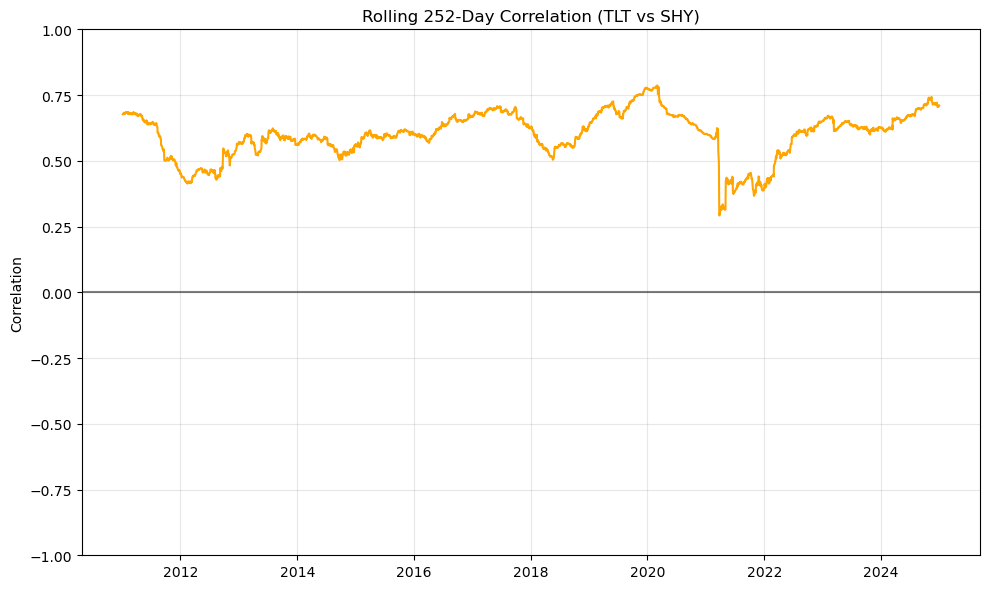

In [15]:
plt.figure(figsize=(10, 6))
rolling_corr = data['TLT_Return'].rolling(252).corr(data['SHY_Return'])
plt.plot(data.index, rolling_corr, color='orange', linewidth=1.5)
plt.title('Rolling 252-Day Correlation (TLT vs SHY)')
plt.ylabel('Correlation')
plt.ylim(-1, 1)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Plot 5: TLT vs SHY Relative Performance Distribution

This histogram shows the **distribution of daily relative performance between TLT and SHY**, measured as the difference in their daily returns. The red dashed vertical line at zero marks the point where both ETFs perform equally. Values to the right indicate days when TLT outperformed SHY (typically during yield curve flattening or falling long-term yields), while values to the left represent days when SHY outperformed TLT (often during rising long-term yields). This visualization helps assess the symmetry, skewness, and variability of their relative return behavior.


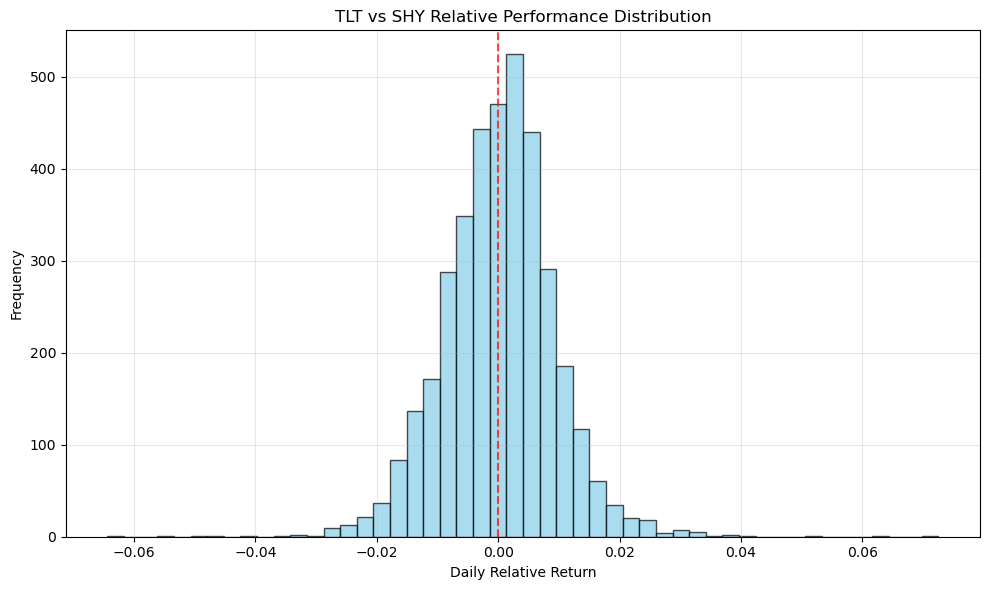

In [16]:
plt.figure(figsize=(10, 6))
data['Relative_Performance'].hist(bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--', alpha=0.7)
plt.title('TLT vs SHY Relative Performance Distribution')
plt.xlabel('Daily Relative Return')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Plot 6: Yield Levels

Here we try to plot the historical yield levels of key U.S. Treasury maturities — the 2-year, 10-year, and 30-year bonds. By tracking these yields over time, we can observe how short-, medium-, and long-term interest rates move in different economic environments. This helps visualize shifts in the absolute level of interest rates (e.g., during tightening or easing cycles) and provides context for understanding yield curve dynamics such as steepening, flattening, or inversion.

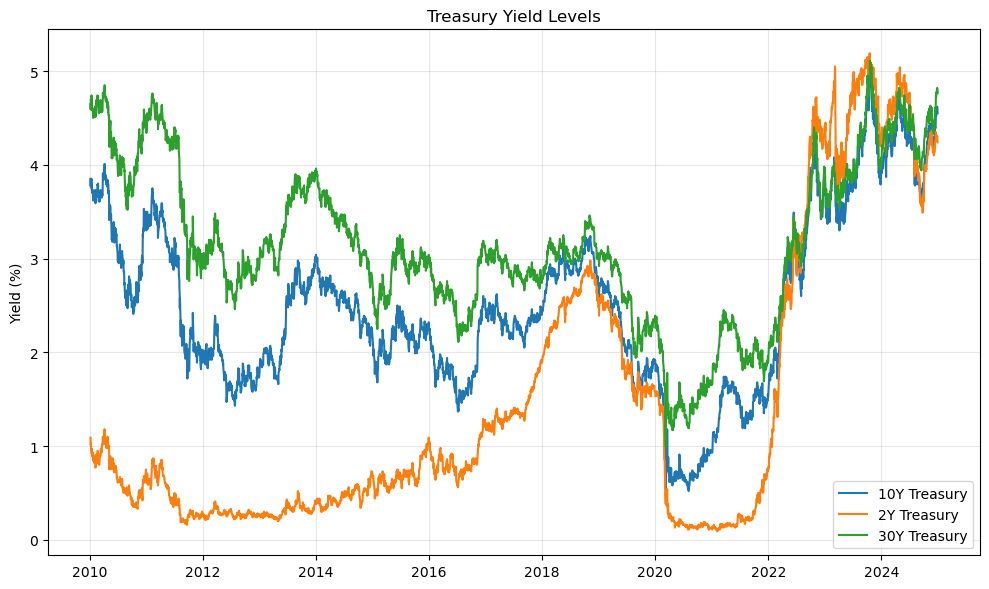

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['10Y'], label='10Y Treasury', linewidth=1.5)
plt.plot(data.index, data['2Y'], label='2Y Treasury', linewidth=1.5)
plt.plot(data.index, data['30Y'], label='30Y Treasury', linewidth=1.5)
plt.title('Treasury Yield Levels')
plt.ylabel('Yield (%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Plot 7: Volatility Comparison

Calculate and visualize the rolling annualized volatility of TLT and SHY. Specifically, we use a 63-day rolling window (roughly one quarter of trading days) to compute the standard deviation of daily returns, then scale it by √252 to annualize the measure. This provides a time-varying estimate of risk for long-duration (TLT) and short-duration (SHY) Treasuries, allowing us to compare how their volatility evolves over time and observe periods when bond market uncertainty is elevated or subdued.

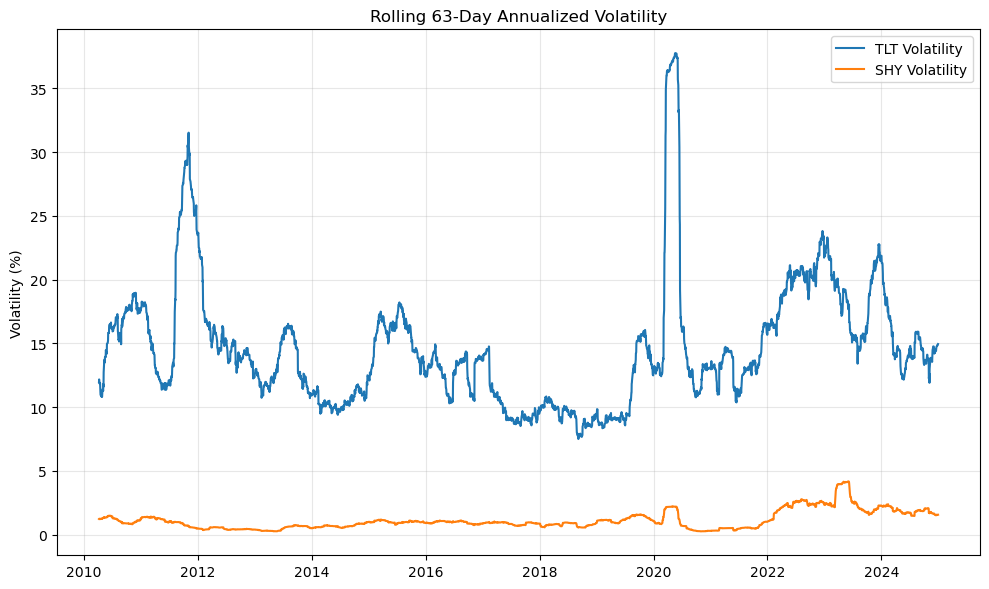

In [18]:
plt.figure(figsize=(10, 6))
tlt_vol = data['TLT_Return'].rolling(63).std() * np.sqrt(252) * 100  # Annualized %
shy_vol = data['SHY_Return'].rolling(63).std() * np.sqrt(252) * 100
plt.plot(data.index, tlt_vol, label='TLT Volatility', linewidth=1.5)
plt.plot(data.index, shy_vol, label='SHY Volatility', linewidth=1.5)
plt.title('Rolling 63-Day Annualized Volatility')
plt.ylabel('Volatility (%)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Plot 8: Economic Regime Analysis

This scatter plot examines the **relationship between the yield curve slope (10Y–2Y spread) and the relative performance of TLT versus SHY**. Each point represents a trading day, with colors indicating different yield curve regimes: red for inversions (spread < 0), green for steep yield curves (top 30% of spreads), orange for flat curves (bottom 30%), and gray for neutral periods. The y-axis shows TLT–SHY relative returns in basis points, highlighting how bond performance shifts under different curve shapes. This visualization helps assess whether yield curve dynamics systematically influence long- vs short-duration Treasury performance.

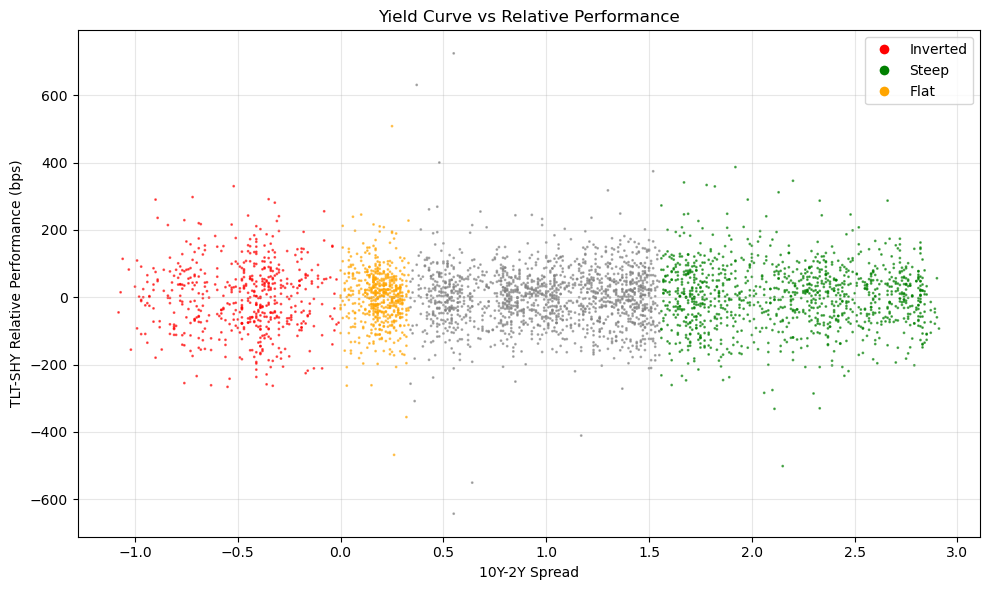

In [19]:
plt.figure(figsize=(10, 6))
if 'Yield_Spread_10Y2Y' in data.columns:
    # Color code by yield curve regime
    steepening = data['Yield_Spread_10Y2Y'] > data['Yield_Spread_10Y2Y'].quantile(0.7)
    flattening = data['Yield_Spread_10Y2Y'] < data['Yield_Spread_10Y2Y'].quantile(0.3)
    
    colors = ['red' if inv else 'green' if steep else 'orange' if flat else 'gray' 
             for inv, steep, flat in zip(data['Yield_Spread_10Y2Y'] < 0, steepening, flattening)]
    
    plt.scatter(data['Yield_Spread_10Y2Y'], data['Relative_Performance'] * 10000, 
               c=colors, alpha=0.6, s=1)
    plt.xlabel('10Y-2Y Spread')
    plt.ylabel('TLT-SHY Relative Performance (bps)')
    plt.title('Yield Curve vs Relative Performance')
    plt.grid(True, alpha=0.3)
    
    # Add legend
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='Inverted'),
                      Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=8, label='Steep'),
                      Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=8, label='Flat')]
    plt.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

## Statistical Analysis

Here, we compute **basic descriptive statistics** for the key metrics in our analysis: the daily returns of TLT and SHY, their relative performance, and the 10Y–2Y Treasury yield spread. Using `.describe()`, we obtain measures such as the mean, standard deviation, minimum, maximum, and quartiles. This provides a concise overview of each variable’s central tendency, dispersion, and range, helping to understand typical behavior, volatility, and extremes in bond returns and yield curve movements over the sample period.


In [20]:
stats_cols = ['TLT_Return', 'SHY_Return', 'Relative_Performance']
stats_cols.append('Yield_Spread_10Y2Y')

basic_stats = data[stats_cols].describe().round(6)
print("Basic Statistics:\n", basic_stats, "\n")

Basic Statistics:
         TLT_Return   SHY_Return  Relative_Performance  Yield_Spread_10Y2Y
count  3744.000000  3744.000000           3744.000000         3745.000000
mean      0.000152     0.000046              0.000106            1.019899
std       0.009663     0.000839              0.009213            0.972266
min      -0.066683    -0.005088             -0.064369           -1.080000
25%      -0.005765    -0.000353             -0.005504            0.240000
50%       0.000558     0.000000              0.000420            1.030000
75%       0.005869     0.000357              0.005533            1.720000
max       0.075196     0.009974              0.072530            2.910000 



### Annualized metrics

We calculate annualized performance metrics for each ETF: TLT, SHY, and SPY. Specifically, we compute:

- Annualized return – the average daily return scaled to a yearly horizon.

- Annualized volatility – the standard deviation of daily returns, scaled to reflect yearly risk.

- Sharpe ratio – a risk-adjusted performance measure, dividing annualized return by annualized volatility.

- Maximum drawdown – the largest peak-to-trough decline in cumulative returns, capturing downside risk.

In [21]:

for etf in ['TLT', 'SHY', 'SPY']:
    if f'{etf}_Return' in data.columns:
        returns = data[f'{etf}_Return'].dropna()
        
        ann_return = (1 + returns.mean()) ** 252 - 1
        ann_vol = returns.std() * np.sqrt(252)
        sharpe = ann_return / ann_vol if ann_vol > 0 else 0
        
        cumret = (1 + returns).cumprod()
        max_dd = (cumret / cumret.cummax() - 1).min()
        
        print(f"{etf}: Return={ann_return:.2%}, Vol={ann_vol:.2%}, Sharpe={sharpe:.2f}, MaxDD={max_dd:.2%}")

print()

TLT: Return=3.89%, Vol=15.34%, Sharpe=0.25, MaxDD=-48.35%
SHY: Return=1.15%, Vol=1.33%, Sharpe=0.87, MaxDD=-5.71%
SPY: Return=15.50%, Vol=17.10%, Sharpe=0.91, MaxDD=-33.72%



### Correlations

In this section, we compute the **correlation matrix** for daily returns of TLT, SHY, SPY, and the 10Y–2Y yield spread. Correlations measure the strength and direction of linear relationships between variables, with values ranging from –1 (perfect negative correlation) to +1 (perfect positive correlation). This analysis helps identify how bond returns move relative to each other and to equities, and how they relate to yield curve changes, providing insight into co-movement and diversification potential across these assets.


In [22]:
corr_cols = ['TLT_Return', 'SHY_Return', 'SPY_Return', 'Yield_Spread_10Y2Y']
corr_matrix = data[corr_cols].corr().round(3)
print("Correlation Matrix:\n", corr_matrix, "\n")

Correlation Matrix:
                     TLT_Return  SHY_Return  SPY_Return  Yield_Spread_10Y2Y
TLT_Return               1.000       0.567      -0.321               0.008
SHY_Return               0.567       1.000      -0.121              -0.021
SPY_Return              -0.321      -0.121       1.000               0.004
Yield_Spread_10Y2Y       0.008      -0.021       0.004               1.000 



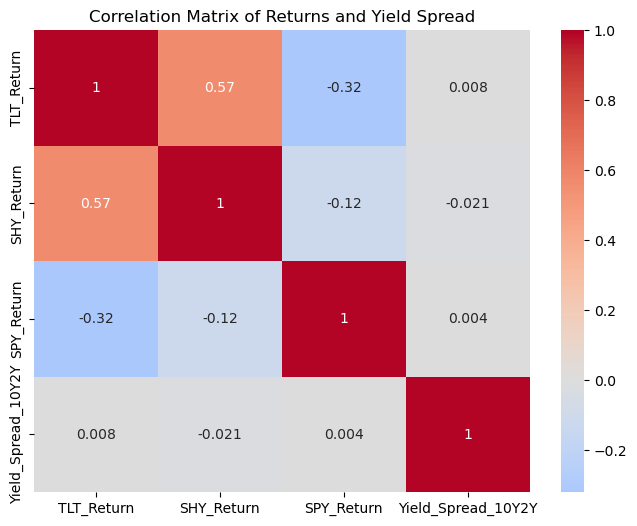

In [23]:
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Returns and Yield Spread')
plt.show()

### Yield curve analysis

We analyze the 10Y–2Y Treasury yield spread to assess the shape and behavior of the yield curve. We calculate the average spread, its volatility, the maximum and minimum values, and the number and percentage of days when the curve was inverted (spread < 0). This provides a concise summary of the yield curve’s historical level, variability, and the frequency of inversions, which are often associated with economic slowdowns or recession signals.

In [24]:
spread = data['Yield_Spread_10Y2Y'].dropna()
inversions = (spread < 0).sum()
pct_inverted = inversions / len(spread) * 100

print(f"Yield Curve (10Y-2Y): mean={spread.mean():.3f}%, vol={spread.std():.3f}%, "
      f"days inverted={inversions} ({pct_inverted:.1f}%), "
      f"max={spread.max():.3f}%, min={spread.min():.3f}%\n")

Yield Curve (10Y-2Y): mean=1.020%, vol=0.972%, days inverted=543 (14.5%), max=2.910%, min=-1.080%



### Regime analysis
In this section, we perform a **regime analysis** of the 10-year Treasury yield by categorizing it into low, medium, and high regimes based on its historical distribution. Specifically, we calculate the percentage of days when yields were in the **lowest third** (low-rate regime) and the **highest third** (high-rate regime), along with the **average yield** and its full range. This analysis helps contextualize periods of historically low or high interest rates and provides insight into the macroeconomic environment over time.


In [25]:
if '10Y' in data.columns:
    yield_10y = data['10Y'].dropna()
    low_rate = (yield_10y < yield_10y.quantile(0.33)).sum() / len(yield_10y) * 100
    high_rate = (yield_10y > yield_10y.quantile(0.67)).sum() / len(yield_10y) * 100
    
    print(f"10Y Yield Regimes: low={low_rate:.1f}%, high={high_rate:.1f}%, "
          f"avg={yield_10y.mean():.2f}%, range={yield_10y.min():.2f}% - {yield_10y.max():.2f}%")

10Y Yield Regimes: low=33.0%, high=33.0%, avg=2.50%, range=0.52% - 4.98%


## Performance Evaluation

In [26]:
# Clean returns data
tlt_returns = data['TLT_Return'].fillna(0)
shy_returns = data['SHY_Return'].fillna(0)
spy_returns = data['SPY_Return'].fillna(0)

In [27]:
# Performance metrics function
def calc_performance_metrics(returns):
    total_return = (1 + returns).prod() - 1
    n_years = len(returns) / 252
    ann_return = (1 + total_return) ** (1/n_years) - 1 if n_years > 0 else 0
    ann_vol = returns.std() * np.sqrt(252)
    sharpe = ann_return / ann_vol if ann_vol > 0 else 0
    
    # Drawdown
    cumret = (1 + returns).cumprod()
    rolling_max = cumret.cummax()
    drawdown = cumret / rolling_max - 1
    max_dd = drawdown.min()
    
    # Win rate
    win_rate = (returns > 0).sum() / (returns != 0).sum() if (returns != 0).sum() > 0 else 0
    
    # Calmar ratio
    calmar = ann_return / abs(max_dd) if max_dd != 0 else 0
    
    return {
        'Total Return': total_return,
        'Annualized Return': ann_return, 
        'Annualized Volatility': ann_vol,
        'Sharpe Ratio': sharpe,
        'Max Drawdown': max_dd,
        'Win Rate': win_rate,
        'Calmar Ratio': calmar
    }

## Calculate metrics

In [28]:
tlt_metrics = calc_performance_metrics(tlt_returns)
shy_metrics = calc_performance_metrics(shy_returns)
spy_metrics = calc_performance_metrics(spy_returns)

## Comparison table
We create a comparison table that consolidates the performance metrics for TLT, SHY, and SPY into a single DataFrame. Each row represents an asset, and each column contains key metrics such as annualized return, volatility, Sharpe ratio, maximum drawdown, and other risk-adjusted measures. This table allows for a straightforward comparison of risk and return characteristics across long-term bonds, short-term bonds, and equities.

In [29]:
comparison_df = pd.DataFrame({
    'TLT (Long Bonds)': tlt_metrics,
    'SHY (Short Bonds)': shy_metrics,
    'SPY (Stocks)': spy_metrics
}).T

In [30]:
# Format output
for col in comparison_df.columns:
    if col in ['Total Return', 'Annualized Return', 'Annualized Volatility', 'Max Drawdown']:
        comparison_df[col] = comparison_df[col].apply(lambda x: f"{x:.2%}")
    elif col in ['Win Rate']:
        comparison_df[col] = comparison_df[col].apply(lambda x: f"{x:.1%}")
    else:
        comparison_df[col] = comparison_df[col].apply(lambda x: f"{x:.2f}")

print("📊 Strategy Performance Comparison:\n")
print(comparison_df.to_string())

# Save results
performance_comparison = comparison_df

📊 Strategy Performance Comparison:

                  Total Return Annualized Return Annualized Volatility Sharpe Ratio Max Drawdown Win Rate Calmar Ratio
TLT (Long Bonds)        48.09%             2.68%                15.34%         0.17      -48.35%    52.4%         0.06
SHY (Short Bonds)       18.44%             1.15%                 1.33%         0.86       -5.71%    52.8%         0.20
SPY (Stocks)           583.77%            13.81%                17.10%         0.81      -33.72%    55.5%         0.41


The results reveal distinct risk-return profiles for long-term bonds (TLT), short-term bonds (SHY), and equities (SPY):

- TLT (Long Bonds): Delivered moderate total returns (48%) but with high volatility (15.3%) and a very low Sharpe ratio (0.17), reflecting the riskiness of long-duration bonds during rising rate periods. Its maximum drawdown of –48% highlights significant downside exposure, although the win rate is slightly above 50%, indicating gains slightly outweigh losses.

- SHY (Short Bonds): Showed low returns (18%) but extremely low volatility (1.3%) and the highest Sharpe ratio (0.86), making it the most stable option. Its drawdowns are minimal (–5.7%), and the win rate is similar to TLT, demonstrating consistent but modest performance.

- SPY (Stocks): Achieved the highest total and annualized returns (584% total, 13.8% annualized) with volatility comparable to TLT (17.1%). The Sharpe ratio (0.81) indicates strong risk-adjusted performance, and the maximum drawdown (–33.7%) shows significant market risk, but the win rate (55.5%) is slightly higher than both bond ETFs.

Overall, SHY excels in stability, SPY excels in growth, and TLT shows moderate returns but substantial risk, illustrating the trade-offs between duration, risk, and return across these asset classes.